<a href="https://colab.research.google.com/github/deendiran/ICS-Project/blob/main/ICS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install earthengine-api

In [3]:
import ee

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-ndirangudenise61')

In [5]:
# Define the area of interest (AOI) and time range
aoi = ee.Geometry.Point([36.8219, -1.2921])  # Example point in Nairobi, Kenya
start_date = '2023-01-01'
end_date = '2023-01-31'

# Load Sentinel-1 SAR data
sentinel1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))  # Interferometric Wide (IW) mode is standard for Sentinel-1

# Retrieve the first image from the collection
sentinel1_image = sentinel1_collection.first()


In [6]:
# Load Sentinel-2 MSI data
sentinel2_collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Limit cloud cover for clearer imagery

# Retrieve the first image from the collection
sentinel2_image = sentinel2_collection.first()


In [13]:
pip install folium

In [14]:
import folium

In [15]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    # Convert Earth Engine image to a tile layer for Folium
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the custom function to the folium Map class
folium.Map.add_ee_layer = add_ee_layer


In [16]:
# Define visualization parameters
sentinel1_vis_params = {
    'min': -25,
    'max': 0,
    'bands': ['VV']
}

# Display Sentinel-1 image
import folium
Map = folium.Map(location=[-1.2921, 36.8219], zoom_start=10)
Map.add_ee_layer(sentinel1_image, sentinel1_vis_params, 'Sentinel-1 VV')
Map


In [17]:
# Define visualization parameters
sentinel2_vis_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']  # True color (RGB)
}

# Display Sentinel-2 image
Map.add_ee_layer(sentinel2_image, sentinel2_vis_params, 'Sentinel-2 RGB')
Map


In [18]:
# Export Sentinel-1 data
export_sentinel1 = ee.batch.Export.image.toDrive(
    image=sentinel1_image.select('VV'),
    description='Sentinel1_VV',
    scale=10,
    region=aoi.buffer(5000).bounds(),  # Buffer the point for an area around it
    fileFormat='GeoTIFF'
)
export_sentinel1.start()


In [19]:
# Export Sentinel-2 data
export_sentinel2 = ee.batch.Export.image.toDrive(
    image=sentinel2_image.select(['B4', 'B3', 'B2']),  # RGB bands
    description='Sentinel2_RGB',
    scale=10,
    region=aoi.buffer(5000).bounds(),
    fileFormat='GeoTIFF'
)
export_sentinel2.start()


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
pip install rasterio

In [28]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

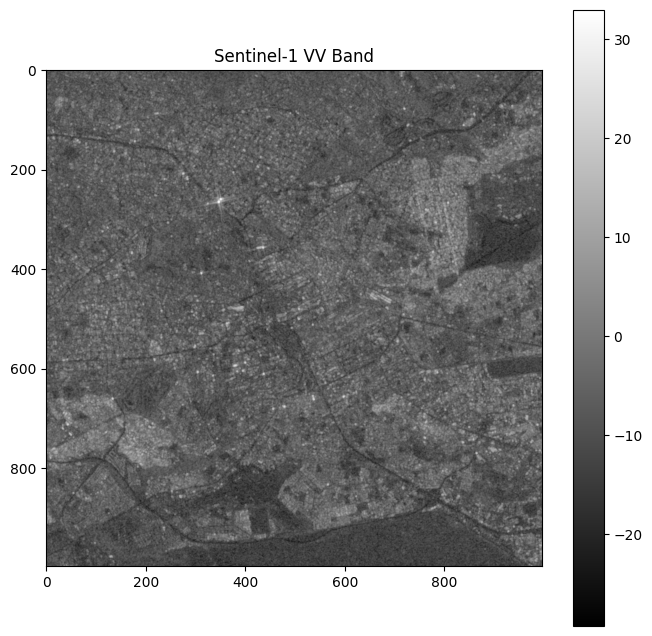

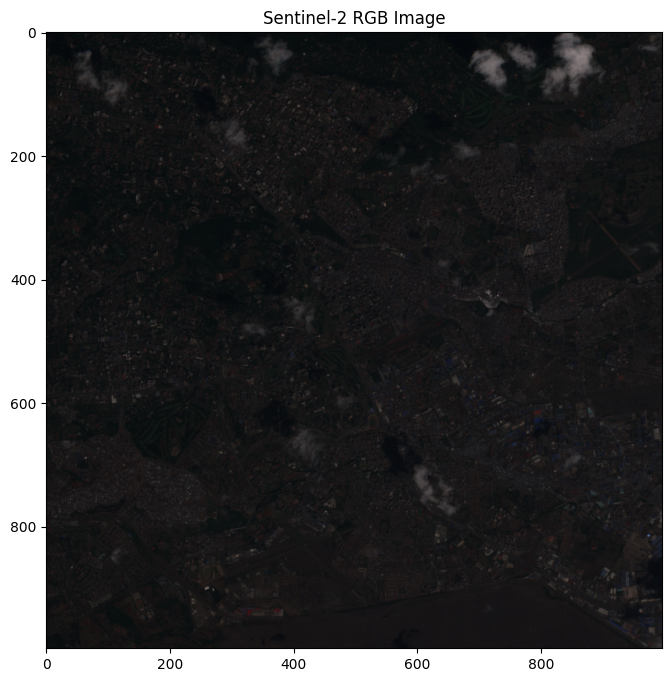

In [30]:
# Load Sentinel-1 image
with rasterio.open('/content/drive/MyDrive/Sentinel1_VV.tif') as src:
    sentinel1_image = src.read(1)  # Read the VV band

# Load Sentinel-2 RGB image
with rasterio.open('/content/drive/MyDrive/Sentinel2_RGB.tif') as src:
    sentinel2_red = src.read(1)    # Band 4 (Red)
    sentinel2_green = src.read(2)  # Band 3 (Green)
    sentinel2_blue = src.read(3)   # Band 2 (Blue)

# Display Sentinel-1 Image
plt.figure(figsize=(8, 8))
plt.imshow(sentinel1_image, cmap='gray')
plt.colorbar()
plt.title("Sentinel-1 VV Band")
plt.show()

# Display Sentinel-2 RGB Image
rgb_image = np.dstack((sentinel2_red, sentinel2_green, sentinel2_blue))
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image / np.max(rgb_image))  # Normalize for display
plt.title("Sentinel-2 RGB Image")
plt.show()


Sentinel-1 VV Band Summary:
                  VV
count  994009.000000
mean       -6.972138
std         4.883382
min       -29.298052
25%       -10.257768
50%        -7.337120
75%        -4.110668
max        32.978318


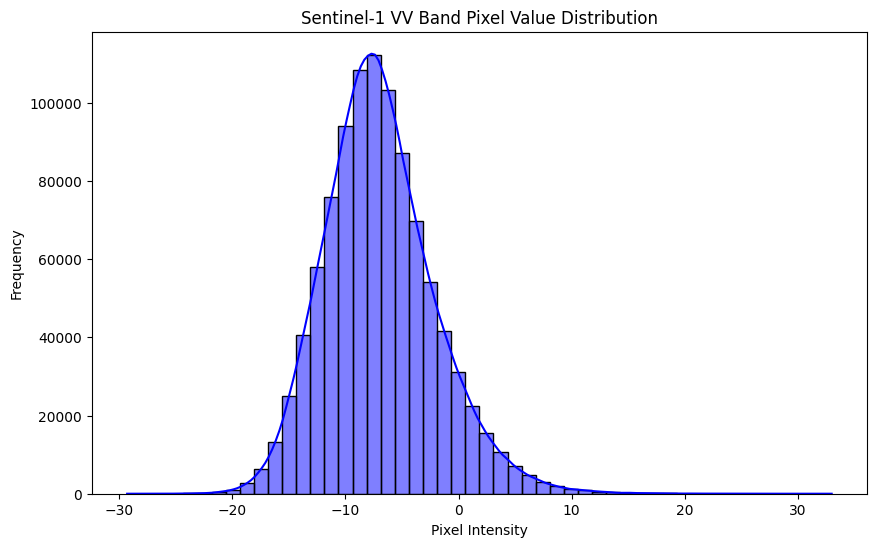

In [31]:
# Convert to DataFrame for EDA
sentinel1_df = pd.DataFrame(sentinel1_image.flatten(), columns=['VV'])

# Summary statistics
print("Sentinel-1 VV Band Summary:")
print(sentinel1_df.describe())

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(sentinel1_df['VV'], bins=50, kde=True, color='blue')
plt.title("Sentinel-1 VV Band Pixel Value Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


Sentinel-2 RGB Bands Summary:
                 Red          Green           Blue
count  994009.000000  994009.000000  994009.000000
mean     1127.133889    1116.652746    1160.813571
std       510.618293     414.275357     407.415631
min       235.000000     243.000000     599.000000
25%       814.000000     904.000000     940.000000
50%      1101.000000    1051.000000    1095.000000
75%      1320.000000    1218.000000    1258.000000
max      7810.000000    8236.000000   13255.000000


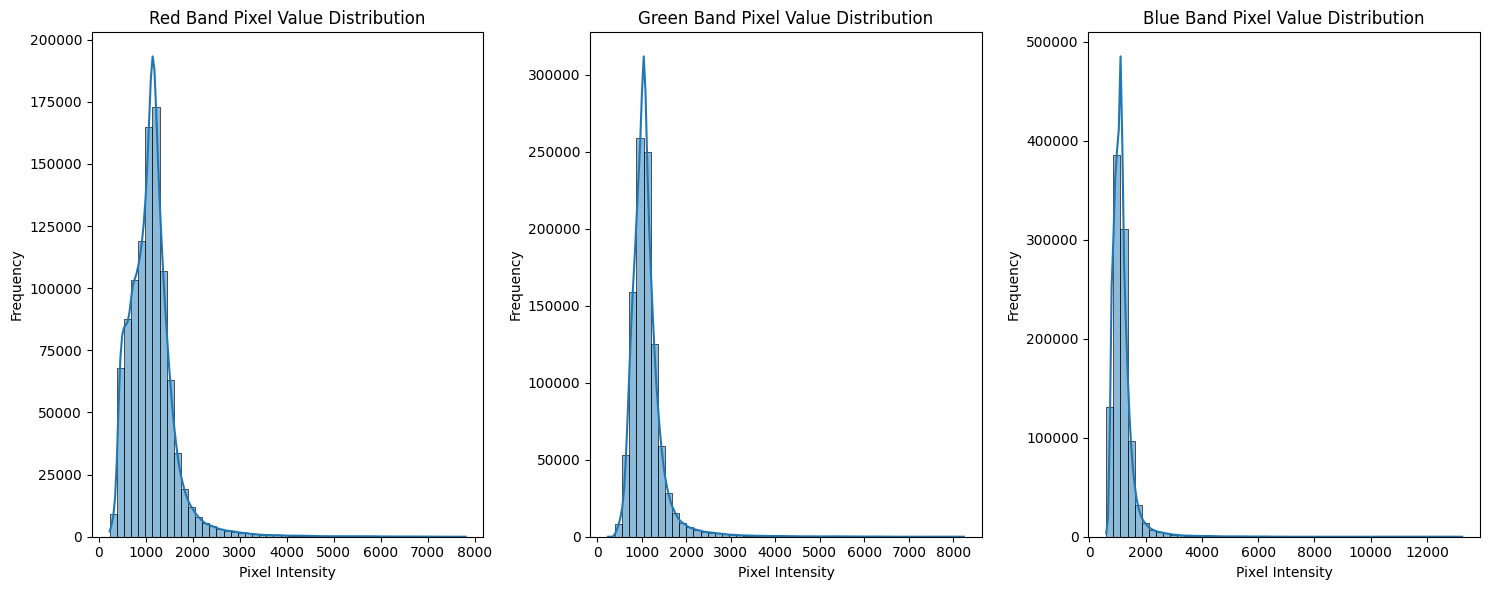

In [32]:
# Flatten and combine bands for EDA
sentinel2_df = pd.DataFrame({
    'Red': sentinel2_red.flatten(),
    'Green': sentinel2_green.flatten(),
    'Blue': sentinel2_blue.flatten()
})

# Summary statistics
print("Sentinel-2 RGB Bands Summary:")
print(sentinel2_df.describe())

# Distribution plot for each band
plt.figure(figsize=(15, 6))
for i, band in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(sentinel2_df[band], bins=50, kde=True)
    plt.title(f"{band} Band Pixel Value Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


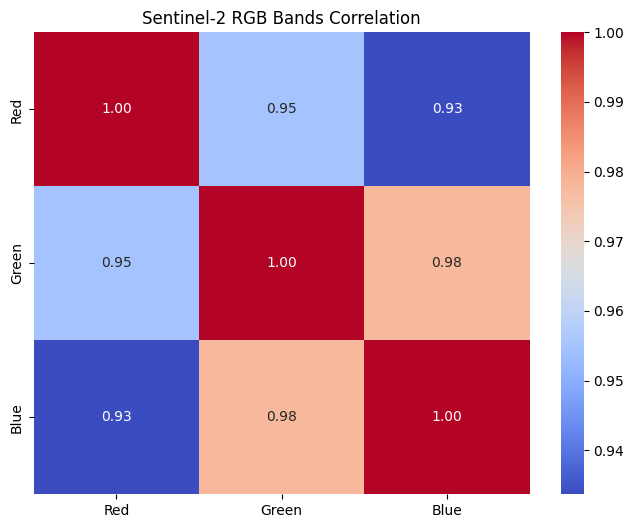

In [33]:
# Correlation matrix
correlation_matrix = sentinel2_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sentinel-2 RGB Bands Correlation")
plt.show()

